# INTRODUCTION

We try to predict the genetic disorder of patients based on multiple features

# IMPORT & SETUP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dense, Input
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import xgboost as xgb
#from lazypredict.Supervised import LazyClassifier
#from pycaret.classification import *

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, mean_absolute_error, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression


# THE DATASET

##### Features: 
###### We see here an example entry from the dataset, we count 45 features, two of which are target features

In [19]:
file_path = 'data/train.csv' 
data = pd.read_csv(file_path)

i = 0
for column in data.columns:
    print(i, "\t ", column)
    i = i+1


0 	  Patient Id
1 	  Patient Age
2 	  Genes in mother's side
3 	  Inherited from father
4 	  Maternal gene
5 	  Paternal gene
6 	  Blood cell count (mcL)
7 	  Patient First Name
8 	  Family Name
9 	  Father's name
10 	  Mother's age
11 	  Father's age
12 	  Institute Name
13 	  Location of Institute
14 	  Status
15 	  Respiratory Rate (breaths/min)
16 	  Heart Rate (rates/min
17 	  Test 1
18 	  Test 2
19 	  Test 3
20 	  Test 4
21 	  Test 5
22 	  Parental consent
23 	  Follow-up
24 	  Gender
25 	  Birth asphyxia
26 	  Autopsy shows birth defect (if applicable)
27 	  Place of birth
28 	  Folic acid details (peri-conceptional)
29 	  H/O serious maternal illness
30 	  H/O radiation exposure (x-ray)
31 	  H/O substance abuse
32 	  Assisted conception IVF/ART
33 	  History of anomalies in previous pregnancies
34 	  No. of previous abortion
35 	  Birth defects
36 	  White Blood cell count (thousand per microliter)
37 	  Blood test result
38 	  Symptom 1
39 	  Symptom 2
40 	  Symptom 3
41 	  S

##### Target features

In [20]:
disease_col = 'Genetic Disorder'  
subclass_col = 'Disorder Subclass'  


grouped_data = data.groupby([disease_col, subclass_col]).size().reset_index(name='Count')
num_combinations = grouped_data.shape[0]


print("Number of entries in the dataset:", len(data))

print("\nUnique Combinations of Disease and Subclass:")
grouped_data.head(10)




Number of entries in the dataset: 22083

Unique Combinations of Disease and Subclass:


,Genetic Disorder,Disorder Subclass,Count
0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,587
1,Mitochondrial genetic inheritance disorders,Leigh syndrome,4683
2,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy,3971
3,Multifactorial genetic inheritance disorders,Alzheimer's,133
4,Multifactorial genetic inheritance disorders,Cancer,91
5,Multifactorial genetic inheritance disorders,Diabetes,1653
6,Single-gene inheritance diseases,Cystic fibrosis,3145
7,Single-gene inheritance diseases,Hemochromatosis,1228
8,Single-gene inheritance diseases,Tay-Sachs,2556


###### There are 3 genetic disorders, each with 3 subclasses. 
###### We notice that there are null entries in the target features, these will not be able to controbute to the model

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


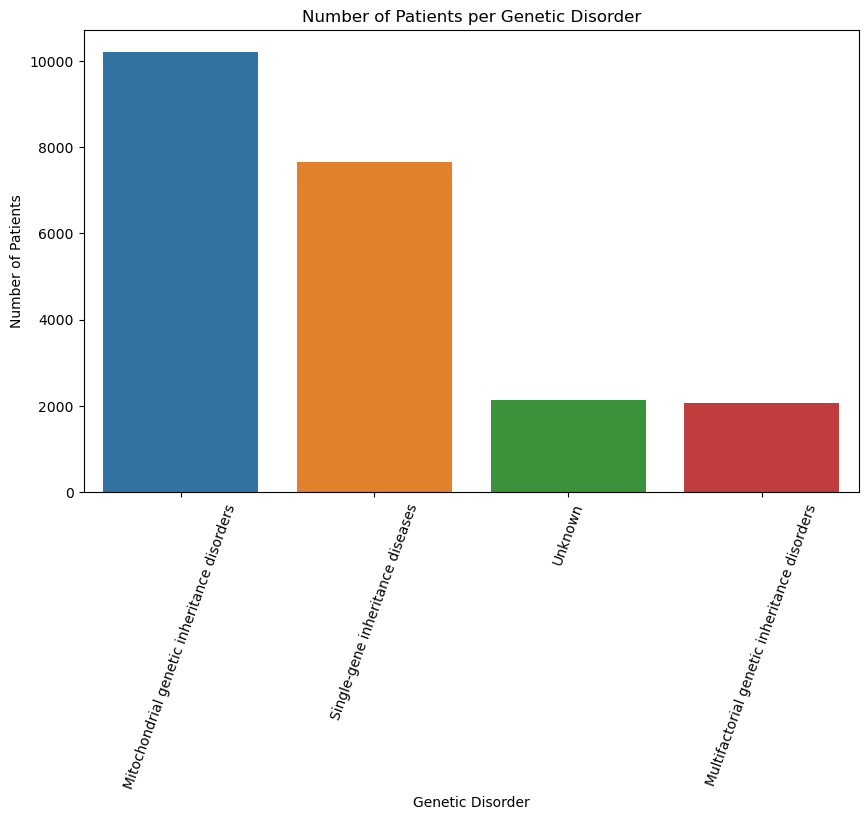

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


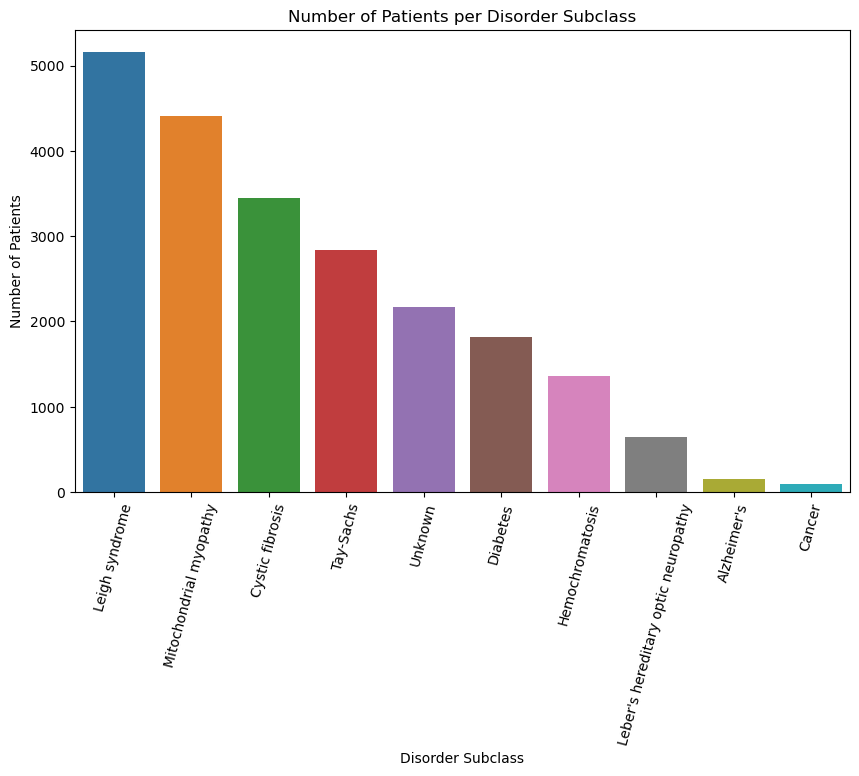

In [21]:
graph_data = data
graph_data[disease_col].fillna('Unknown', inplace=True)
graph_data[subclass_col].fillna('Unknown', inplace=True)


# Counting patients for each disease and subclass
disease_count = graph_data[disease_col].value_counts()
subclass_count = graph_data[subclass_col].value_counts()

# Plotting Bar Chart for Diseases
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_count.index, y=disease_count.values) 
plt.title('Number of Patients per Genetic Disorder')
plt.ylabel('Number of Patients')
plt.xlabel('Genetic Disorder')
plt.xticks(fontsize=10, rotation=70) 
plt.show()

# Plotting Bar Chart for Subclasses
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_count.index, y=subclass_count.values)
plt.title('Number of Patients per Disorder Subclass')
plt.ylabel('Number of Patients')
plt.xlabel('Disorder Subclass')
plt.xticks(fontsize=10, rotation=75) 
plt.show()

In [22]:

for column in data.columns:
    unique_values = data[column].unique()
    nan_counts = data[column].isnull().sum()

    print(f"{column}: {unique_values}: {nan_counts}\n")
    


Patient Id: ['PID0x6418' 'PID0x25d5' 'PID0x4a82' ... 'PID0x3c4f' 'PID0x13a'
 'PID0x9332']: 0

Patient Age: [ 2.  4.  6. 12. 11. 14.  3.  7.  1.  0. nan 10.  5. 13.  8.  9.]: 1427

Genes in mother's side: ['Yes' 'No']: 0

Inherited from father: ['No' 'Yes' nan]: 306

Maternal gene: ['Yes' 'No' nan]: 2810

Paternal gene: ['No' 'Yes']: 0

Blood cell count (mcL): [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]: 0

Patient First Name: ['Richard' 'Mike' 'Kimberly' ... 'Kraig' 'Althea' 'Cathrine']: 0

Family Name: [nan 'Hoelscher' 'Stutzman' ... 'Acuff' 'Farley' 'Mose']: 9691

Father's name: ['Larre' 'Brycen' 'Nashon' ... 'Quientin' 'Bomer' 'Eban']: 0

Mother's age: [nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]: 6036

Father's age: [nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59

# PRE-PROCESSING

---------------------------------------DATA OVERVIEW-------------------------------------
Patient Age: [ 2.  4.  6. 12. 14.  3. 11.  7.  1.  0. 10.  5. 13.  8.  9.]: 0

Genes in mother's side: [1. 0.]: 0

Inherited from father: [ 0.  1. -1.]: 236

Maternal gene: [1. 0.]: 0

Paternal gene: [0. 1.]: 0

Blood cell count (mcL): [-0.5118449   0.04212314 -0.02200419 ...  0.27672303 -0.15030127
 -0.59503787]: 0

Mother's age: [35. 41. 21. 45. 44. 50. 28. 24. 40. 36. 30. 23. 49. 46. 18. 38. 37. 42.
 51. 48. 32. 19. 47. 34. 22. 33. 20. 29. 26. 31. 43. 39. 27. 25.]: 0

Father's age: [42. 23. 22. 63. 44. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 52. 28. 31.
 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59. 47. 38.
 54. 21. 41. 37. 33. 46. 40. 36. 45.]: 0

Status: [0. 1.]: 0

Respiratory Rate (breaths/min): [0. 1.]: 0

Heart Rate (rates/min: [0. 1.]: 0

Parental consent: [1. 0.]: 0

Follow-up: [1. 0.]: 0

Gender: [ 0.5  0.  -0.5]: 0

Birth asphyxia: [-1.  0.  1.]: 5625

Autopsy shows 

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


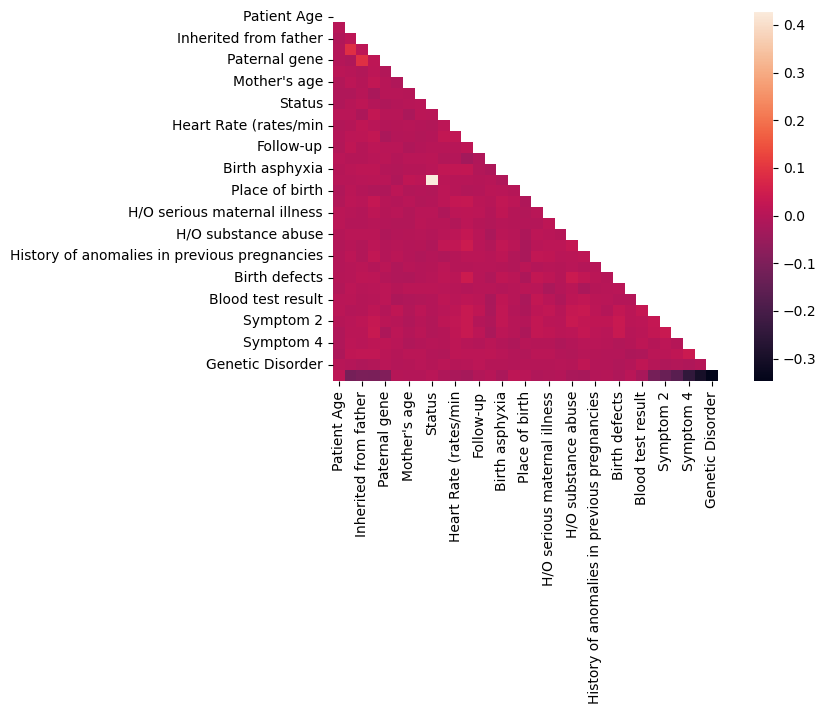

In [23]:
label_encoder = LabelEncoder()

file_path = 'data/train.csv' 
dataset = pd.read_csv(file_path)

#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#

# remove rows where both targets NaN
dataset = dataset.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')

# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                     'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
dataset = dataset.drop(columns=columns_to_drop)


# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}


dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']] 
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)


#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#



#  NUMERICAL --> MEDIAN IMPUTER
imputer = SimpleImputer(strategy='median')
dataset['Patient Age'] = imputer.fit_transform(dataset[['Patient Age']])
dataset["Mother\'s age"] = imputer.fit_transform(dataset[['Mother\'s age']])
dataset["Father\'s age"] = imputer.fit_transform(dataset[['Father\'s age']])
dataset['No. of previous abortion'] = imputer.fit_transform(dataset[['No. of previous abortion']])
dataset['White Blood cell count (thousand per microliter)'] = imputer.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])


# SCALE
robust_scaler = RobustScaler()
dataset['White Blood cell count (thousand per microliter)'] = robust_scaler.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])
dataset['Blood cell count (mcL)'] = robust_scaler.fit_transform(dataset[['Blood cell count (mcL)']])
dataset['No. of previous abortion'] = robust_scaler.fit_transform(dataset[['No. of previous abortion']])




# CATEGORIAL BINARY
mode_imputer = SimpleImputer(strategy='most_frequent')
dataset['Autopsy shows birth defect (if applicable)'] = dataset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0}).fillna(0.0)
dataset['Parental consent'] = dataset['Parental consent'].replace('Yes', 1.0).fillna(0.0)
dataset['H/O substance abuse'] = dataset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0}).fillna(-1.0)
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes':1.0}).fillna(-1.0)
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes':1.0}).fillna(0.0)
dataset['History of anomalies in previous pregnancies'] = dataset['History of anomalies in previous pregnancies'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O serious maternal illness'] = dataset['H/O serious maternal illness'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0}).fillna(0.0)

dataset['Place of birth'] = dataset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
dataset['Place of birth'] = mode_imputer.fit_transform(dataset[['Place of birth']])
# NaN non imputed --> -1.0
dataset['Birth asphyxia'] = dataset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': -1.0, 'Yes':1.0}).fillna(-1.0)

dataset['Respiratory Rate (breaths/min)'] = dataset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
dataset['Respiratory Rate (breaths/min)'] = mode_imputer.fit_transform(dataset[['Respiratory Rate (breaths/min)']]) 

dataset['Heart Rate (rates/min'] = dataset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
dataset['Heart Rate (rates/min'] = mode_imputer.fit_transform(dataset[['Heart Rate (rates/min']])
dataset['Follow-up'] = dataset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
dataset['Follow-up'] = mode_imputer.fit_transform(dataset[['Follow-up']])

dataset['Folic acid details (peri-conceptional)'] = dataset['Folic acid details (peri-conceptional)'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Assisted conception IVF/ART'] = dataset['Assisted conception IVF/ART'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Birth defects'] = dataset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0}).fillna(-1.0)

# CATEGORIAL MULTICLASS
dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0}).fillna(2.0)
dataset['Gender'] = robust_scaler.fit_transform(dataset[['Gender']])
dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0}).fillna(-1.0)
dataset['Blood test result'] = robust_scaler.fit_transform(dataset[['Blood test result']])

# BINARY FEATURES WITH NO NaN
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Status"] = dataset["Status"].replace({'Alive': 0.0, 'Deceased': 1.0})

dataset['Symptom 1'] = dataset['Symptom 1'].fillna(-1.0)
dataset['Symptom 2'] = dataset['Symptom 2'].fillna(-1.0)
dataset['Symptom 3'] = dataset['Symptom 3'].fillna(-1.0)
dataset['Symptom 4'] = dataset['Symptom 4']
dataset['Symptom 5'] = dataset['Symptom 5']
dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#


print("---------------------------------------DATA OVERVIEW-------------------------------------")
i=1
for column in dataset.columns:
    i=i+1
    unique_values = dataset[column].unique()
    nan_counts = (dataset[column] == -1.0).sum()

    print(f"{column}: {unique_values}: {nan_counts}\n")
print(i)
print("---------------------------------------END DATA OVERVIEW-------------------------------------")    


heat_data = dataset.copy()
heat_data['Genetic Disorder'] = label_encoder.fit_transform(heat_data['Genetic Disorder'])
heat_data['Disorder Subclass'] = label_encoder.fit_transform(heat_data['Disorder Subclass'])

corr = heat_data.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

# Random forest model 58%

In [24]:
#----------------------------------PREDICTION 1 RANDOM FOREST--------------------------------------#


# PREPARE DATA: Define X and y, split into test/validation/train

rf_data = dataset.copy()
rf_data['Genetic Disorder'] = label_encoder.fit_transform(rf_data['Genetic Disorder'])
rf_data['Disorder Subclass'] = label_encoder.fit_transform(rf_data['Disorder Subclass'])


training_data = rf_data.drop(["Mother's age", 'Birth asphyxia', 'Autopsy shows birth defect (if applicable)'], axis=1)
X = training_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
y_genetic = rf_data['Genetic Disorder']
y_subclass = rf_data['Disorder Subclass']



X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)


# Random Forest Classifier

model_genetic = RandomForestClassifier(verbose=0, random_state=1, n_jobs=-1, class_weight='balanced_subsample',
                                 n_estimators=300,max_depth=10, 
                                 min_samples_split = 10, min_samples_leaf = 5
                                )

#model_genetic = RandomForestClassifier(random_state=42)
model_genetic.fit(X_train, y_train_genetic)
y_pred_genetic = model_genetic.predict(X_test)

accuracy_genetic = accuracy_score(y_test_genetic, y_pred_genetic)
f1_genetic = f1_score(y_test_genetic, y_pred_genetic, average='weighted')
print(f"Genetic Disorder - Accuracy: {accuracy_genetic}, F1 Score: {f1_genetic}")


model_subclass = RandomForestClassifier(verbose=0, random_state=1, n_jobs=-1, class_weight='balanced_subsample',
                                 n_estimators=300,max_depth=10, 
                                 min_samples_split = 10, min_samples_leaf = 5
                                )
#model_subclass = RandomForestClassifier(random_state=42)
model_subclass.fit(X_train, y_train_subclass)
y_pred_subclass = model_subclass.predict(X_test)

accuracy_subclass = accuracy_score(y_test_subclass, y_pred_subclass)
f1_subclass = f1_score(y_test_subclass, y_pred_subclass, average='weighted')
print(f"Disorder Subclass - Accuracy: {accuracy_subclass}, F1 Score: {f1_subclass}")




Genetic Disorder - Accuracy: 0.5818688981868898, F1 Score: 0.5718668250034583
Disorder Subclass - Accuracy: 0.34198047419804745, F1 Score: 0.3335716294906091


# Keras neural network (3 layer) 60%

In [33]:
#--------------------------------PREDICTION 2   Keras neural network------------------------------#

nn_data = dataset.copy()
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
nn_data['Genetic Disorder'] = nn_data['Genetic Disorder'].map(genetic_disorder_mapping)



y = np.array(list(nn_data['Genetic Disorder']))


print(y.shape)


X = nn_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='gelu'))
model.add(Dense(32, activation='gelu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with 3 neurons for 3 classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

best_accuracy = max(history.history['val_accuracy']) * 100 
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")



(17921, 3)
Epoch 1/100
1291/1291 [==============================] - 6s 3ms/step - loss: 1.0247 - accuracy: 0.4643 - val_loss: 0.9281 - val_accuracy: 0.5091
Epoch 2/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.9202 - accuracy: 0.4892 - val_loss: 0.9210 - val_accuracy: 0.5139
Epoch 3/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.9030 - accuracy: 0.4988 - val_loss: 0.8726 - val_accuracy: 0.5356
Epoch 4/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.8790 - accuracy: 0.5252 - val_loss: 0.8797 - val_accuracy: 0.5397
Epoch 5/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.8600 - accuracy: 0.5549 - val_loss: 0.8852 - val_accuracy: 0.5439
Epoch 6/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.8466 - accuracy: 0.5677 - val_loss: 0.8377 - val_accuracy: 0.5781
Epoch 7/100
1291/1291 [==============================] - 4s 3ms/step - loss: 0.8399 - accuracy: 0.5745 - val_loss: 0.83

In [34]:

nn_data_2 = dataset.copy()


genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
nn_data_2['Genetic Disorder'] = nn_data_2['Genetic Disorder'].map(genetic_disorder_mapping)

nn_data_2 = nn_data_2.dropna(subset=['Disorder Subclass'])
disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

nn_data_2['Disorder Subclass'] = nn_data_2['Disorder Subclass'].map(disorder_subclass_mapping)

# Prepare targets
y_genetic = np.array(list(nn_data_2['Genetic Disorder']))
y_subclass = np.array(list(nn_data_2['Disorder Subclass']))

X = nn_data_2.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)


X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)


input_layer = Input(shape=(X_train.shape[1],))
hidden1 = Dense(128, activation='relu')(input_layer)
hidden2 = Dense(64, activation='relu')(hidden1)
hidden3 = Dense(32, activation='relu')(hidden2)
output_genetic = Dense(y_train_genetic.shape[1], activation='softmax', name='genetic_output')(hidden3)
output_subclass = Dense(y_train_subclass.shape[1], activation='softmax', name='subclass_output')(hidden3)

model = Model(inputs=input_layer, outputs=[output_genetic, output_subclass])


model.compile(optimizer='adam', loss={'genetic_output': 'categorical_crossentropy', 'subclass_output': 'categorical_crossentropy'}, metrics=['accuracy'])


history = model.fit(X_train, {'genetic_output': y_train_genetic, 'subclass_output': y_train_subclass}, epochs=75, batch_size=10, validation_split=0.1)

# Evaluate the model
loss, genetic_loss, subclass_loss, genetic_accuracy, subclass_accuracy = model.evaluate(X_test, {'genetic_output': y_test_genetic, 'subclass_output': y_test_subclass})


best_genetic_accuracy = max(history.history['val_genetic_output_accuracy']) * 100 
print(f"Best Validation Accuracy: {best_genetic_accuracy:.2f}%")
best_subclass_accuracy = max(history.history['val_subclass_output_accuracy']) * 100 
print(f"Best Validation Accuracy: {best_subclass_accuracy:.2f}%")

best_genetic_accuracy = np.mean(history.history['val_genetic_output_accuracy']) * 100 
print(f"Average Validation Accuracy: {best_genetic_accuracy:.2f}%")
best_subclass_accuracy = np.mean(history.history['val_subclass_output_accuracy']) * 100 
print(f"Average Validation Accuracy: {best_subclass_accuracy:.2f}%")



Epoch 1/75
1187/1187 [==============================] - 7s 4ms/step - loss: 2.7404 - genetic_output_loss: 0.9512 - subclass_output_loss: 1.7891 - genetic_output_accuracy: 0.4759 - subclass_output_accuracy: 0.2851 - val_loss: 2.5358 - val_genetic_output_loss: 0.9131 - val_subclass_output_loss: 1.6227 - val_genetic_output_accuracy: 0.5064 - val_subclass_output_accuracy: 0.3146
Epoch 2/75
1187/1187 [==============================] - 4s 4ms/step - loss: 2.3713 - genetic_output_loss: 0.8722 - subclass_output_loss: 1.4991 - genetic_output_accuracy: 0.5401 - subclass_output_accuracy: 0.3523 - val_loss: 2.4652 - val_genetic_output_loss: 0.8847 - val_subclass_output_loss: 1.5805 - val_genetic_output_accuracy: 0.5497 - val_subclass_output_accuracy: 0.3366
Epoch 3/75
1187/1187 [==============================] - 5s 4ms/step - loss: 2.3021 - genetic_output_loss: 0.8474 - subclass_output_loss: 1.4547 - genetic_output_accuracy: 0.5710 - subclass_output_accuracy: 0.3598 - val_loss: 2.2923 - val_geneti

# Complete subset (all NaN values dropped)

In [4]:
test_data = pd.read_csv('data/train.csv')

test_data = test_data.dropna()

label_encoder = LabelEncoder()


# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                     'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Parental consent']
test_data = test_data.drop(columns=columns_to_drop)




imputer = SimpleImputer(strategy='median')
numeric = test_data._get_numeric_data().columns
for column in numeric:
    test_data[column] = imputer.fit_transform(test_data[[column]])


robust_scaler = RobustScaler()
test_data['White Blood cell count (thousand per microliter)'] = robust_scaler.fit_transform(test_data[['White Blood cell count (thousand per microliter)']])
test_data['Blood cell count (mcL)'] = robust_scaler.fit_transform(test_data[['Blood cell count (mcL)']])
test_data['No. of previous abortion'] = robust_scaler.fit_transform(test_data[['No. of previous abortion']])


test_data['Autopsy shows birth defect (if applicable)'] = test_data['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0})
test_data['H/O radiation exposure (x-ray)'] = test_data['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0})
test_data['H/O substance abuse'] = test_data['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0})
#test_data['Parental consent'] = test_data['Parental consent'].replace('Yes', 1.0)
test_data['Birth asphyxia'] = test_data['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': 0.0, 'Yes':1.0})


test_data['Gender'] = test_data['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0})
test_data['Gender'] = robust_scaler.fit_transform(test_data[['Gender']])
test_data['Blood test result'] = test_data['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0})
test_data['Blood test result'] = robust_scaler.fit_transform(test_data[['Blood test result']])

test_data['Birth defects'] = test_data['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0})
test_data['Place of birth'] = test_data['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
test_data['Respiratory Rate (breaths/min)'] = test_data['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
test_data['Heart Rate (rates/min'] = test_data['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
test_data['Follow-up'] = test_data['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
test_data['Status'] = test_data['Status'].replace({'Alive': 0.0, 'Deceased': 1.0})


columns_to_replace = [
    'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status'
]
for col in columns_to_replace:
    test_data[col] = test_data[col].replace({'Yes': 1.0, 'No': 0.0})


columns_to_scale = [
    'Blood test result', 
    'White Blood cell count (thousand per microliter)', 
    'No. of previous abortion', 
    'Gender', 
    'Blood cell count (mcL)',
    "Mother's age", 
    "Father's age", 
    "Patient Age"
]

scaler = MinMaxScaler()
for col in columns_to_scale:
    test_data[col] = scaler.fit_transform(test_data[[col]])

print("---------------------------------------DATA OVERVIEW-------------------------------------")
i=1
for colu in test_data.columns:
    i=i+1
    unique_values = test_data[colu].unique()
    nan_counts = (test_data[colu].isna()).sum()

    print(f"{colu}: {unique_values}: {nan_counts}\n")
print(i)
print("---------------------------------------END DATA OVERVIEW-------------------------------------")    


genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
test_data['Genetic Disorder'] = test_data['Genetic Disorder'].map(genetic_disorder_mapping)

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

test_data['Disorder Subclass'] = test_data['Disorder Subclass'].map(disorder_subclass_mapping)

test_data.info()

# Prepare targets
y_genetic = np.array(list(test_data['Genetic Disorder']))
y_subclass = np.array(list(test_data['Disorder Subclass']))

X = test_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)


X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)


input_layer = Input(shape=(X_train.shape[1],))
hidden1 = Dense(256, activation='sigmoid')(input_layer)
hidden2 = Dense(128, activation='sigmoid')(hidden1)
hidden3 = Dense(64, activation='sigmoid')(hidden2)
hidden4 = Dense(32, activation='sigmoid')(hidden3)

output_genetic = Dense(y_train_genetic.shape[1], activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)

output_subclass = Dense(y_train_subclass.shape[1], activation='softmax',
                        name='subclass_output',
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model = Model(inputs=input_layer, outputs=[output_genetic, output_subclass])


model.compile(optimizer='adam', loss={'genetic_output': 'categorical_crossentropy', 'subclass_output': 'categorical_crossentropy'}, metrics=['accuracy'])


history = model.fit(X_train, {'genetic_output': y_train_genetic, 'subclass_output': y_train_subclass}, epochs=25, batch_size=10, validation_split=0.1, callbacks=[reduce_lr])

# Evaluate the model
loss, genetic_loss, subclass_loss, genetic_accuracy, subclass_accuracy = model.evaluate(X_test, {'genetic_output': y_test_genetic, 'subclass_output': y_test_subclass})


best_genetic_accuracy = max(history.history['val_genetic_output_accuracy']) * 100 
print(f"Best genetic validation Accuracy: {best_genetic_accuracy:.2f}%")
best_subclass_accuracy = max(history.history['val_subclass_output_accuracy']) * 100 
print(f"Best subclass validation Accuracy: {best_subclass_accuracy:.2f}%")

average_genetic_accuracy = np.mean(history.history['val_genetic_output_accuracy']) * 100
print(f"Average genetic validation Accuracy: {average_genetic_accuracy:.2f}%")

# Calculate the average accuracy across all epochs for validation
average_subclass_accuracy = np.mean(history.history['val_subclass_output_accuracy']) * 100
print(f"Average subclass validation Accuracy: {average_subclass_accuracy:.2f}%")

---------------------------------------DATA OVERVIEW-------------------------------------
Patient Age: [0.78571429 0.28571429 0.42857143 0.71428571 0.57142857 0.07142857
 0.35714286 0.14285714 0.21428571 0.64285714 1.         0.85714286
 0.5        0.         0.92857143]: 0

Genes in mother's side: [0. 1.]: 0

Inherited from father: [0. 1.]: 0

Maternal gene: [1. 0.]: 0

Paternal gene: [0. 1.]: 0

Blood cell count (mcL): [0.72617436 0.41407641 0.32398906 ... 0.66347821 0.43099624 0.63632435]: 0

Mother's age: [0.81818182 0.78787879 0.6969697  0.66666667 0.54545455 0.36363636
 0.93939394 0.         0.60606061 0.57575758 0.15151515 0.84848485
 0.3030303  0.42424242 0.03030303 0.45454545 0.96969697 1.
 0.18181818 0.51515152 0.90909091 0.75757576 0.06060606 0.87878788
 0.12121212 0.48484848 0.24242424 0.72727273 0.21212121 0.63636364
 0.09090909 0.39393939 0.33333333 0.27272727]: 0

Father's age: [0.54545455 0.5        0.         0.84090909 0.63636364 0.18181818
 0.25       0.93181818 0.34

# XG Boost model 57%

In [40]:

#----------------------------------PREDICTION 3 XGBOOST MODEL--------------------------------------#
xgb_data = dataset.copy()
xgb_data['Genetic Disorder'] = label_encoder.fit_transform(xgb_data['Genetic Disorder'])# XG Boost model 57%
X = xgb_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
y = xgb_data['Genetic Disorder']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.2f}")

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

XGBoost Model Accuracy: 0.57


c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i